In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from datetime import datetime

In [2]:
def read_df_system(file, machine):
    # Read CSV data
    # Skip first row as it's useless
    # Only select the desired columns
    # Make sure #Date, Time columns are strings so we can easily parse them later
    df = pd.read_csv(file, skiprows = 1,
        usecols = ['#Date', 'Time', '[CPU]Totl%', '[MEM]Tot', '[MEM]Used', '[NET]RxKBTot', '[NET]TxKBTot'],
        dtype = {
            '#Date': str,
            'Time': str
        })

    # Build a time series with Timestamp objects from the #Date, Time columns
    timeseries = df[['#Date', 'Time']].apply(
        lambda s: pd.Timestamp(
            year = int(s[0][:4]),
            month = int(s[0][4:6]),
            day = int(s[0][6:]),
            hour = int(s[1].split(':')[0]),
            minute = int(s[1].split(':')[1]),
            second = int(s[1].split(':')[2])
        )
    , axis = 1)

    # Build a timedelta-based index
    test_start = timeseries.iloc[0]
    timeindex = timeseries.apply(lambda s: (s - test_start))

    df.index = pd.MultiIndex.from_product([[machine], timeindex], names = ['machine', 'time'])

    df.rename(columns = {
        '[CPU]Totl%': 'cpu_%',
        '[MEM]Tot': 'mem_total_kb',
        '[MEM]Used': 'mem_used_kb',
        '[NET]RxKBTot': 'net_recv_kb',
        '[NET]TxKBTot': 'net_send_kb'
    }, inplace = True)

    df.insert(4, 'mem_%', (df['mem_used_kb'] / df['mem_total_kb'] * 100).round().astype(int))

    df.drop(columns = ['#Date', 'Time', 'mem_total_kb', 'mem_used_kb'], inplace = True)

    return df

def read_dfs_system(app, storage, test_name, test_size):
    df = read_df_system(f'{app}/{storage}/{test_name}_{test_size}/cloud74_{test_name}_{test_size}_system.csv', 'cloud74')
    
    for i in range(75, 77):
        df2 = read_df_system(f'{app}/{storage}/{test_name}_{test_size}/cloud{i}_{test_name}_{test_size}_system.csv', f'cloud{i}')

        df = df.append(df2)
    
    return df

In [3]:
df = read_dfs_system('nextcloud', 'nfs', 'staticWrite', 100)
df


cpu_%  mem_%  net_recv_kb  net_send_kb
machine time                                                   
cloud74 0 days 00:00:00      8     92           44           84
        0 days 00:00:05      7     92           19           25
        0 days 00:00:10      6     92           41           65
        0 days 00:00:15      7     92           23           13
        0 days 00:00:20      7     92           83           55
...                        ...    ...          ...          ...
cloud76 0 days 00:16:35      9     97           34           30
        0 days 00:16:40      8     97           35           25
        0 days 00:16:45      8     97           28           24
        0 days 00:16:50     16     98          444          350
        0 days 00:16:55     11     97           31           39

[612 rows x 4 columns]

In [4]:
cpu_usage = df['cpu_%'].reset_index().pivot(index='time', columns = 'machine', values = ['cpu_%'])['cpu_%'].median(axis=1).rolling(2).mean().dropna()
cpu_usage

time
0 days 00:00:05    13.0
0 days 00:00:10    12.5
0 days 00:00:15    12.0
0 days 00:00:20    12.5
0 days 00:00:25    12.5
                   ... 
0 days 00:16:35     9.0
0 days 00:16:40     8.5
0 days 00:16:45     8.0
0 days 00:16:50     9.0
0 days 00:16:55    11.0
Length: 203, dtype: float64

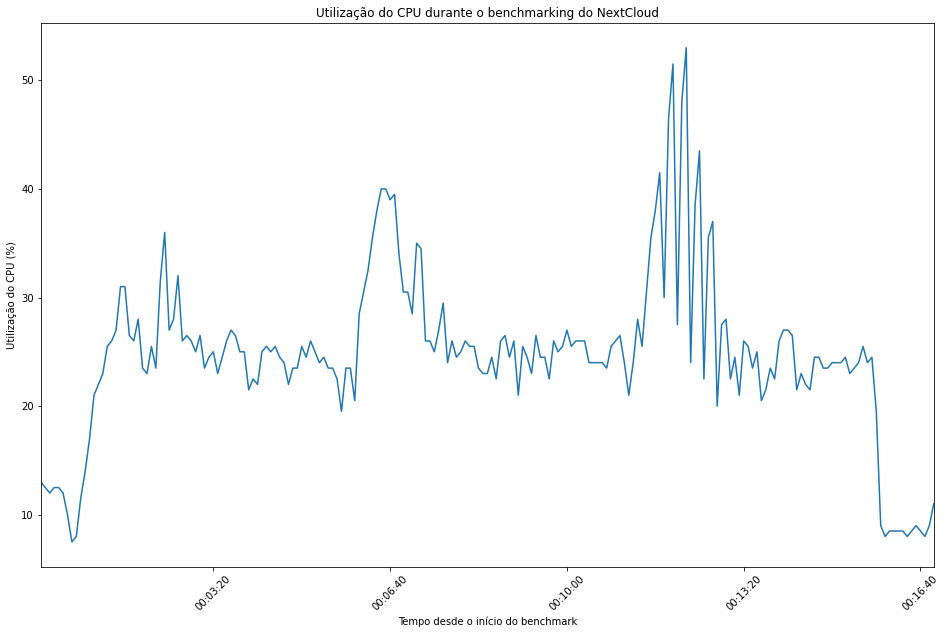

In [5]:
fig, ax = plt.subplots(figsize=(16, 10))

cpu_usage.plot(
    ax = ax,
    legend = False
)

ax.set_title('Utilização do CPU durante o benchmarking do NextCloud')

ax.set_xlabel('Tempo desde o início do benchmark')
ax.set_ylabel('Utilização do CPU (%)')

ax.tick_params(axis = 'x', labelrotation = 45)

# ax.legend(bbox_to_anchor=(1.1, 1))

plt.show()

In [6]:
def make_cpu_mem_graph(app, storage, test_name, test_size, graph_type = 'cpu', close = True):
    column_name = graph_type + '_%'

    fig, ax = plt.subplots(figsize=(16, 10))
    
    df = read_dfs_system(app, storage, test_name, test_size)[[column_name]]

    usage = df.reset_index() \
        .pivot(index='time', columns = 'machine', values = [f'{column_name}'])[f'{column_name}'] \
        .median(axis=1) \
        .rolling(2).mean().dropna()

    usage.plot(
        ax = ax,
        legend = False,
        color = 'blue' if graph_type == 'cpu' else 'red'
    )

    graph_label = "do CPU" if graph_type == "cpu" else "da RAM"

    ax.set_title(f'Utilização mediana {graph_label} pelas três máquinas durante o benchmarking do {app} (rolling avg. 15s, teste de {test_name.replace("static", "")}, backend {storage}, {test_size} utilizadores)')

    ax.set_xlabel('Tempo desde o início do benchmark')
    ax.set_ylabel(f'Utilização {graph_label} (%)')

    ax.tick_params(axis = 'x', labelrotation = 45)

    fig.savefig(f'{app.lower()}/{storage.lower()}/{test_name}_{test_size}/{test_name}_{test_size}_{graph_type}.png')
    # plt.show()

    if close:
        plt.close(fig)

In [7]:
def make_graphs_for_scenario(app, storage, test_name, test_size):
    make_cpu_mem_graph(app, storage, test_name, test_size, 'cpu')
    make_cpu_mem_graph(app, storage, test_name, test_size, 'mem')
    # Faltam os gráficos da network

In [8]:
def make_graphs():
    for app in ['Wiki', 'NextCloud']: # Falta Peertube
        for storage in ['NFS']: # Falta Ceph
            for test_name in ['staticRead', 'staticWrite', 'simulateUser']:
                for test_size in [25, 50, 75, 100]:
                    make_graphs_for_scenario(app, storage, test_name, test_size)

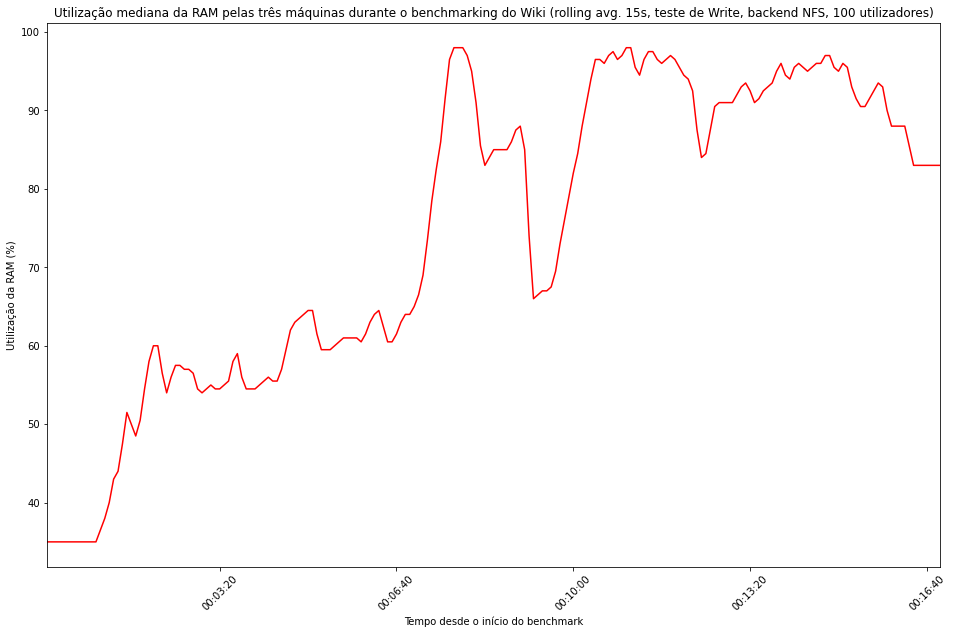

In [9]:
make_cpu_mem_graph('Wiki', 'NFS', 'staticWrite', 100, 'mem', False)

In [10]:
make_graphs()

In [11]:
plt.close('all')